In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2\

import networkx as nx
import numpy as np
import tensorflow as tf

from keras import backend as K
from keras.layers import Dense
from keras.models import Model, Sequential


from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.network.heterogeneous_network import HeterogeneousNetwork
from moge.visualization.plot_data import matrix_heatmap

from sklearn.metrics import pairwise_distances
np.set_printoptions(precision=2, suppress=True)

Using TensorFlow backend.


#  Import network from file

In [2]:
import pickle

# WRITE
# with open('moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_network_test_05_val_01_seed_0.pickle', 'wb') as file:
#     pickle.dump(network, file)

# READ
with open('moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_network_lncbase_train.pickle', 'rb') as file:
# with open('moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_network_biogrid.pickle', 'rb') as file:
    network = pickle.load(file)
#     network.remove_extra_nodes()
#     network.node_list = network.all_nodes
#     node_list = network.node_list

with open('moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_network_lncbase_val.pickle', 'rb') as file:
    network_test = pickle.load(file)

# Load trained Model

In [4]:
from keras.models import load_model
lstm_network = load_model("lstm_network_contrastive_eucl_256_linear_varlen_lncbase_filtered_conv2_random_e10.h5")
lstm_network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 6)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 192)         7104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 192)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 320)         184640    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 320)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 320)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 640)               1640960   
__________

/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Data Generator

In [6]:
batch_size = 1
input_shape = (None, 6)
max_length = 700

In [7]:
from moge.network.data_generator import DataGenerator

generator = DataGenerator(network=network, get_training_data=False, negative_sampling_ratio=2.0,
                          maxlen=max_length, padding='post', truncating="post",
                          batch_size=1, dim=input_shape, 
                          shuffle=True, seed=0)
generator.genes_info = generator.genes_info[generator.genes_info["Transcript sequence"].notna()]

X, y = generator.__getitem__(0)
print("X:", [(k, v.shape) for k, v in X.items()], "\ny:", y.shape)

Genes info columns: ['locus_type', 'location', 'Family', 'Transcript sequence', 'Disease association', 'Transcript length']
Number of nodes without seq removed: 2572
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}
Ed_count: 382165 , Eu_count: 379556 , En_count: 727488
Ens_count: 764330
X: [('input_seq_j', (1, 700, 6)), ('input_seq_i', (1, 700, 6)), ('is_directed', (1, 1))] 
y: (1, 1)


# Get embeddings

In [8]:
seqs = generator.get_sequence_data(range(len(generator.node_list)), variable_length=False)

In [9]:
# embs = [lstm_network.predict(seq, batch_size=1) for seq in seqs]
embs = lstm_network.predict(seqs, batch_size=256)

In [10]:
embs = np.array(embs)
embs = embs.reshape(embs.shape[0], embs.shape[-1])
embs.shape

(32307, 256)

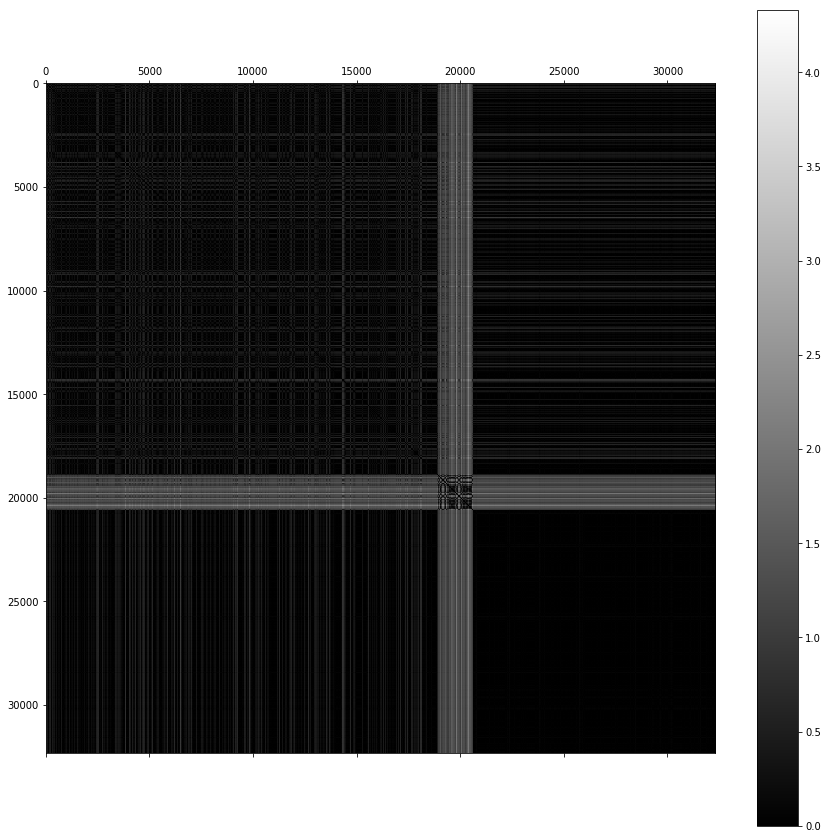

In [11]:
matrix_heatmap(pairwise_distances(embs, n_jobs=8))

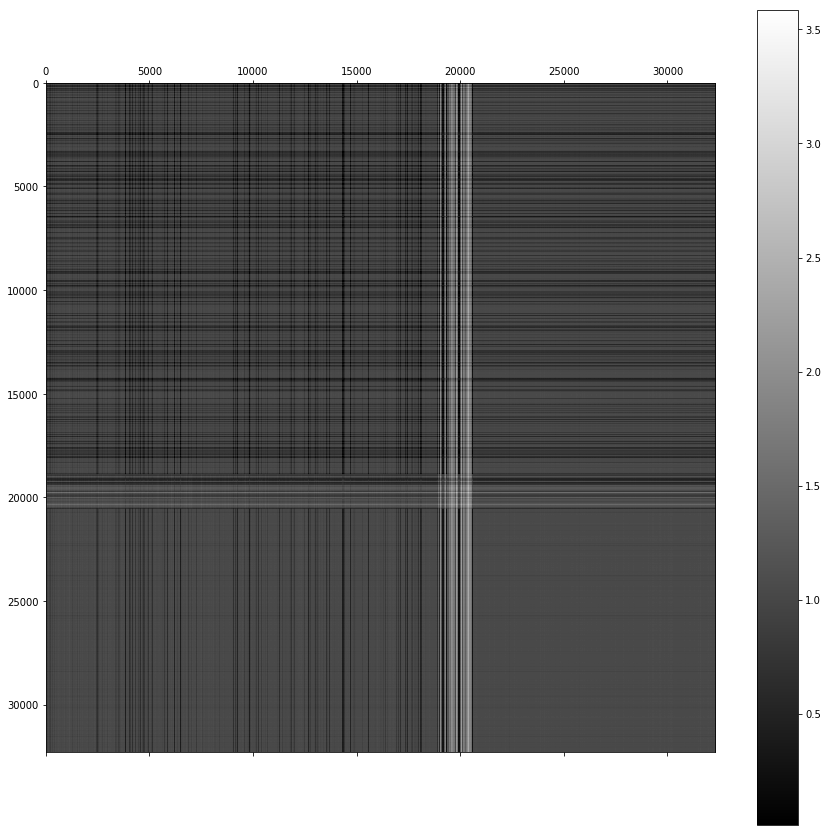

In [12]:
_d = embs.shape[1]
matrix_heatmap(pairwise_distances(embs[:, 0:int(_d/2)], embs[:, int(_d/2):_d], n_jobs=8))

In [13]:
# Write embeddings to file
fout = open("embs_train_32307_256_lncbase_random.emb", 'w')
fout.write("{} {}\n".format(len(generator.node_list), _d))
for i in range(len(generator.node_list)):
    fout.write("{} {}\n".format(generator.node_list[i],
                                    ' '.join([str(x) for x in embs[i]])))
fout.close()

# Read embeddings from file
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding
graph_emb = ImportedGraphEmbedding(d=512, method_name="siamese_switch")
graph_emb.import_embedding("embs_train_32307.emb", node_list=generator.node_list)

embs = graph_emb._X
embs.shape

# Link Prediction

In [ ]:
generator.genes_info.loc[nodelist, label_name].str.split("|", expand=True)[0]

# Node Annotation prediction

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer

label_name = "locus_type"
nodelist = generator.genes_info[generator.genes_info[label_name].notna()].index

# labels = generator.genes_info.loc[nodelist, label_name].str.split("|")
labels = generator.genes_info.loc[nodelist, label_name].str.split("|", expand=True)[0]
labeler = LabelBinarizer()
y = labeler.fit_transform(labels.tolist())

X = embs[[generator.genes_info.index.get_loc(node) for node in nodelist]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(X.shape, y.shape)
print(labeler.classes_)

(32307, 256) (32307, 23)
['RNA, long non-coding' 'RNA, micro' 'TEC' 'antisense'
 'bidirectional_promoter_lncRNA' 'lincRNA' 'misc_RNA' 'non_coding'
 'non_stop_decay' 'nonsense_mediated_decay' 'polymorphic_pseudogene'
 'processed_pseudogene' 'processed_transcript' 'protein_coding'
 'retained_intron' 'scaRNA' 'sense_intronic' 'snRNA' 'snoRNA'
 'transcribed_processed_pseudogene' 'transcribed_unitary_pseudogene'
 'transcribed_unprocessed_pseudogene' 'unprocessed_pseudogene']


In [15]:
from sklearn import svm
from sklearn.linear_model import RidgeClassifierCV, MultiTaskLasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

clf = svm.LinearSVC(multi_class="crammer_singer")
# clf = MLPClassifier(hidden_layer_sizes=(100, 50), activation="logistic", early_stopping=True, verbose=True)
clf.fit(X_train, y_train)

ValueError: bad input shape (21645, 23)

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_test, clf.predict(X_test), pos_label=1, average='micro')

In [23]:
clf.predict(X_test).sum(axis=1)

array([0, 0, 0, ..., 0, 0, 0])

# Visualize Embeddings

In [16]:
from sklearn.metrics.pairwise import pairwise_distances
from moge.visualization.plot_data import matrix_heatmap
from scipy import sparse
# from sklearn.manifold import TSNE
from moge.visualization.visualize_embedding import get_node_color, plot_embedding2D
import matplotlib.pyplot as plt

# matrix_heatmap(sparse.csr_matrix(pairwise_distances(embs[:, 0:int(_d/2)], embs[:, int(_d/2):int(_d)], 
#                                                     metric="euclidean", n_jobs=-1)))

In [17]:
from sklearn.decomposition import PCA

embs_pca = PCA(n_components=2).fit_transform(embs)
embs_pca.shape

(32307, 2)

In [18]:
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(init=embs_pca, perplexity=80, n_jobs=8, verbose=True)
node_pos = tsne.fit_transform(embs)

In [19]:
g = network.G.subgraph(generator.node_list)
# g = nx.relabel.relabel_nodes(g, {k: v for v, k in enumerate(generator.node_list)})

In [20]:
nodelist = generator.genes_info[generator.genes_info["Transcript sequence"].notnull()][
    generator.genes_info["locus_type"].isin([\
                                             "RNA, micro", 
                                             "RNA, long non-coding", 
                                             "protein_coding"
                                            ])].index.tolist()
# nodelist = generator.node_list
len(nodelist)

21841

In [21]:
edgelist = [(u,v) for u, v, d in network_test.G.edges(data=True) if (d["type"]=="d" and (u in nodelist and v in nodelist))]
len(edgelist)

16497

In [22]:
transcript_lengths = generator.genes_info.loc[nodelist]["Transcript length"]
node_colors = [float(s % 1000) / 1000 for s in transcript_lengths]      

In [23]:
locus_types = generator.genes_info.loc[nodelist]["locus_type"]
node_colors = [float(hash(s) % 256) / 256 for s in locus_types]      

In [ ]:
Family = generator.genes_info.loc[nodelist]["Family"]
node_colors = [float(hash(s) % 256) / 256 for s in Family] 

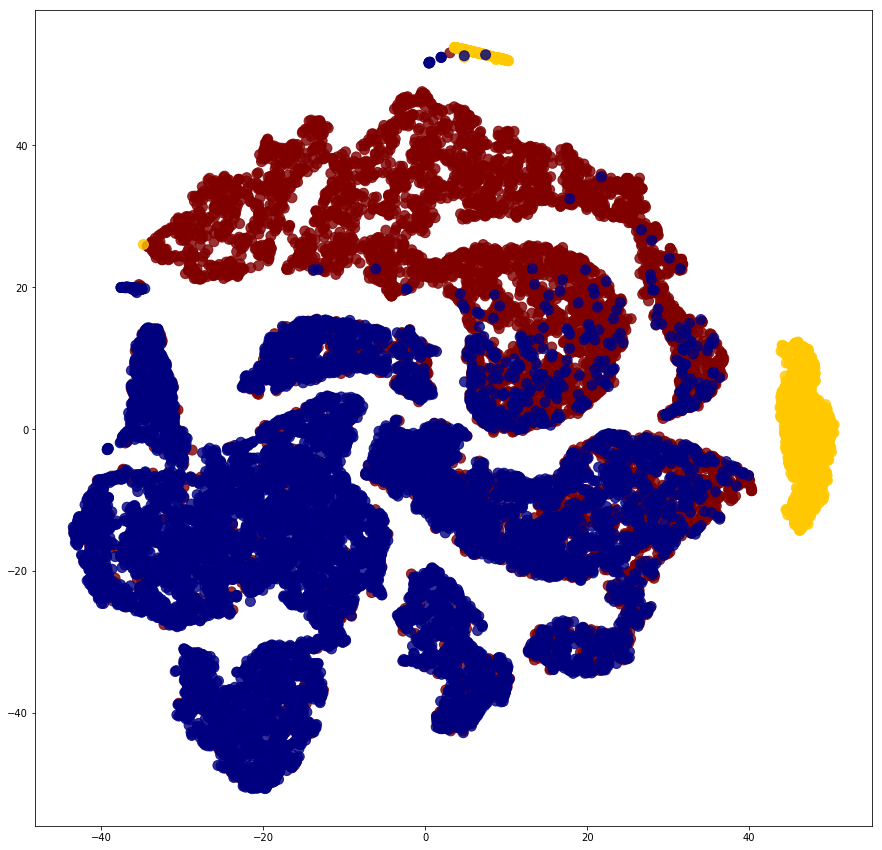

In [24]:
plt.figure(figsize=(15,15))
plot_embedding2D(node_pos, node_list=generator.node_list, node_colors=node_colors,
                 di_graph=g, cmap="jet", plot_nodes_only=True, nodelist=nodelist,
#                  edgelist=edgelist, with_labels=False,
                 label=None
                )